# Web Scraper for Toyota Corolla Sales Data from Wikipedia (2000-2024)

## Description:
## This project is a Python-based web scraper designed to extract, process, and visualize Toyota Corolla sales data from Wikipedia

### Loading of the necessary liabries

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging
import threading
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the link to be Scraped

In [3]:
# Configure logging
logging.basicConfig(filename='scraper.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Wikipedia base URL
base_url = "https://en.wikipedia.org/wiki/Toyota_Corolla"

### Navigate through multiple pages dynamically

In [4]:
# Function to fetch and parse page
def fetch_page(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.RequestException as e:
        logging.error(f"Error fetching {url}: {e}")
        return None

# Function to extract sales data
def extract_sales_data(soup):
    sales_table = None
    for table in soup.find_all('table', {'class': 'wikitable'}):
        if 'Calendar year' in str(table):
            sales_table = table
            break
    
    if sales_table:
        rows = sales_table.find_all('tr')
        headers = [header.text.strip() for header in rows[0].find_all('th')]
        data = []
        
        for row in rows[1:]:
            cols = row.find_all(['td', 'th'])
            cols = [col.text.strip().replace(',', '') for col in cols]
            
            # Ensure row matches header length by padding missing values
            while len(cols) < len(headers):
                cols.append('N/A')  # Fill missing values with 'N/A'
            while len(cols) > len(headers):
                cols = cols[:len(headers)]  # Trim extra values
            
            data.append(cols)
        
        df = pd.DataFrame(data, columns=headers)
        df = df[df['Calendar year'].astype(str).str.isnumeric()]
        df = df[(df['Calendar year'].astype(int) >= 2000) & (df['Calendar year'].astype(int) <= 2024)]
        return df
    else:
        logging.warning("Sales data table not found.")
        return None


###  Visualize sales data

In [ ]:
# Function to visualize sales data
color_palette = ["red", "orange", "yellow", "green", "blue", "purple", "pink", "silver", "gold", "brown", "gray", "black", "white"] # Define colors

def visualize_sales_data(df):
    df.set_index('Calendar year', inplace=True)
    df.replace('N/A', None, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=df, markers=True, dashes=False, palette=color_palette[:len(df.columns)])
    
    plt.yscale('linear')  # Changed from log scale to linear scale for better readability
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.title('Toyota Corolla Sales (2000-2024)')
    plt.legend(df.columns, loc='upper left', bbox_to_anchor=(1,1))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.show()

### Displaying and Store the extracted data in a structured format (CSV/JSON)

Table Headers:
['Calendar year', 'Japan[33]', 'U.S.', 'Canada', 'Mexico', 'Australia', 'Europe', 'Thailand', 'Pakistan[34]', 'India[35]', 'China', 'Argentina', 'Brazil']

Data Head:
   Calendar year Japan[33]        U.S. Canada Mexico  Australia Europe  \
26          2000    162870  230156[53]                30576[54]          
27          2001    236507      245023                    30813          
28          2002    226222  254360[56]                    34948          
29          2003    198904      325477                    36128          
30          2004    173301  333161[59]                    39053          

   Thailand Pakistan[34] India[35]  China Argentina Brazil  
26                  8778                                    
27                  8116                                    
28                  6151                                    
29                 12867      8175                          
30                 20321     10195  45476                   

Data T

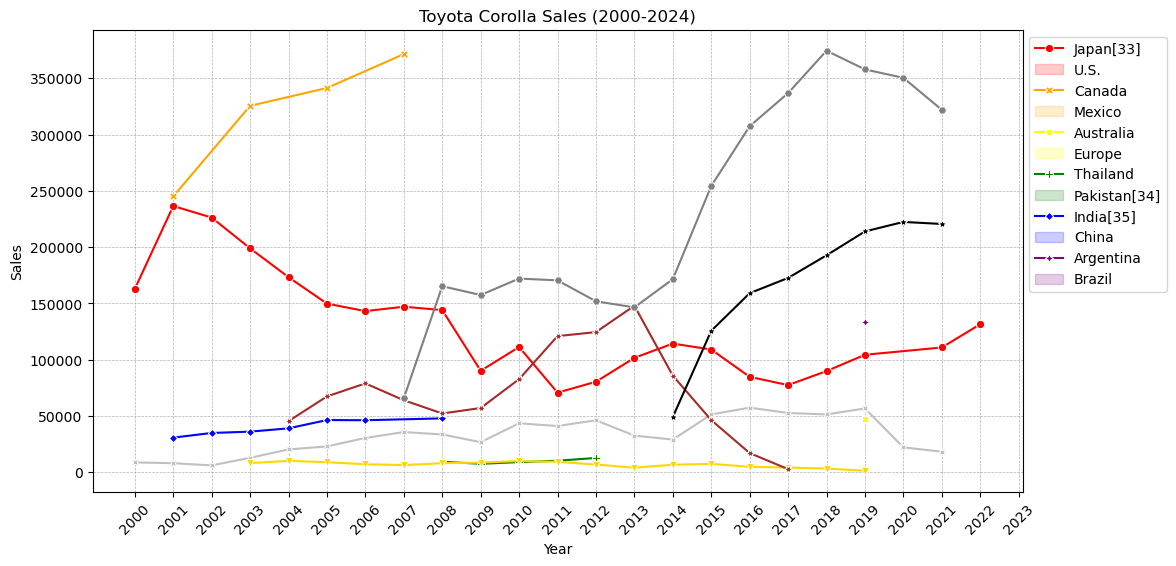

In [5]:
# Fetch and parse Wikipedia page
soup = fetch_page(base_url)

if soup:
    df = extract_sales_data(soup)
    
    if df is not None:
        # Print table header, data head, and tail
        print("Table Headers:")
        print(df.columns.tolist())
        print("\nData Head:")
        print(df.head())
        print("\nData Tail:")
        print(df.tail())
        
        # Save to CSV
        df.to_csv("toyota_corolla_sales.csv", index=False)
        # Save to JSON
        df.to_json("toyota_corolla_sales.json", orient="records", indent=4)
        logging.info("Data successfully saved to CSV and JSON.")
        print("Data saved successfully to toyota_corolla_sales.csv and toyota_corolla_sales.json")
        
        # Visualize the data
        visualize_sales_data(df)
    else:
        print("Failed to extract data.")
else:
    print("Failed to fetch Wikipedia page.")
    